### Punto 3: ARMA TRM

In [39]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dm_test import dm_test
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import warnings; warnings.simplefilter('ignore')

* Importación de la TRM en Formato Excel Serie Histórica desde 1992
https://www.banrep.gov.co/es/estadisticas/trm

<AxesSubplot:xlabel='Fecha'>

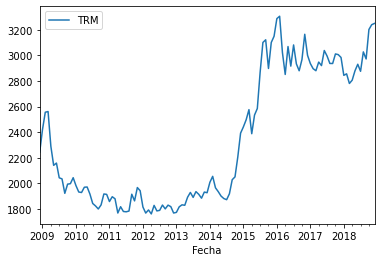

In [40]:
TRMd=pd.read_excel('1.1.1.TCM_Serie histórica IQY.xlsx',skiprows=8, header=None,
                   usecols="A,B",names=["Fecha","TRM"],
                   index_col='Fecha').dropna()

#  Convierte los indices al tipo de dato datetime
TRMd.index = pd.to_datetime(TRMd.index)
# Agrupa los valores correpsondiente al ultimo dia de cada mes
TRMm= TRMd.groupby([TRMd.index.year, TRMd.index.month]).tail(1)

#Datos a pronosticar
TRMm1=TRMm.loc['2018-12':'2019-09']
#Serie datos de pronostico
TRMm2=TRMm.loc['2008-12':'2018-12']

TRMm2.plot()

*  Prueba de Dickey-Fuller aumentada para verificar Estacionariedad de los datos originales

In [41]:
#Prueba de Dickey-fuller aumentado para comprobar estacionareidad de la serie original
pruebaTRMm=adfuller(TRMm2['TRM'])
print(pruebaTRMm)

(-0.16355512845245693, 0.9427286105443486, 7, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 1267.7824855915555)


* Estacionarización de los datos utilizando una transfomación de cambios porcentuales diarios

(-4.4192490574103855, 0.0002743949753069227, 6, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, -407.3723783614846)


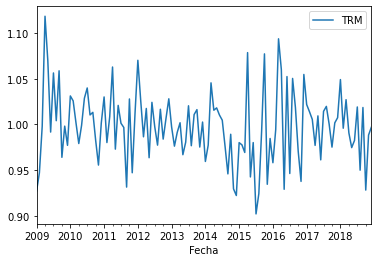

In [42]:
#Transformación de Datos (Cambios proporcionales)
TRM_estacionaria=(TRMm2.shift(1)/TRMm2).dropna() #Periodo de análisis
TRM_estacionaria_1=(TRMm1.shift(1)/TRMm1).dropna() #Periodo de pronóstico
TRM_estacionaria.plot()

#Prueba de Dickey-fuller aumentado para comprobar estacionareidad de la serie transformada
pruebaTRM_estacionaria=adfuller(TRM_estacionaria['TRM'])
print(pruebaTRM_estacionaria)

* Diagramas de autocorrelación total y parcial

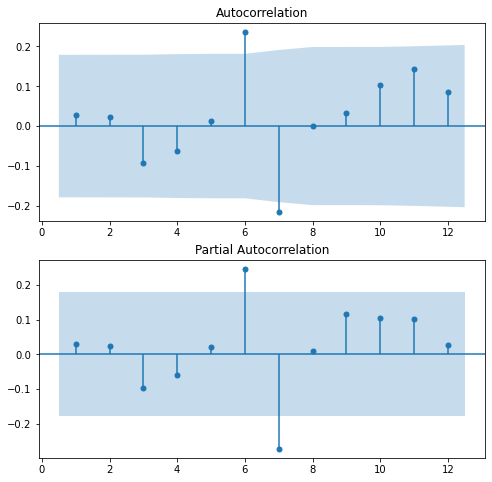

In [43]:
# Diagramas de autocorrelación
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(TRM_estacionaria, lags=12, zero=False, ax=ax1) #Autocorrelacion
plot_pacf(TRM_estacionaria, lags=12, zero=False, ax=ax2)#Autocorrelación parcial
plt.show()

* Iteraciones sobre diferente parámetros de p y q para el modelo ARIMA

In [44]:
order_aic_bic =[] #Lista que contiene los  AIC y BIC para diferentes modelos de ARMA
for p in range(1,3): #Ciclo de factor AR
    for q in range(1,3): #Ciclo factor MA
        model = SARIMAX(TRM_estacionaria,order=(p,0,q)) #Implementación modelo
        results = model.fit() #Ajuste modelo
        order_aic_bic.append((p, q, results.aic, results.bic)) #Almacenamiento AIC y BIC     

* Resultados de criterios de información de Akaike y Bayesiano

In [45]:
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic']) #Convesión lista AIC y BIC en DataFrame
print(order_df)

   p  q         aic         bic
0  1  1 -421.386860 -413.024385
1  1  2 -419.422287 -408.272320
2  2  1 -405.251777 -394.101810
3  2  2 -417.398061 -403.460602


* Definición del rolling window para la estimación del pronóstico

In [46]:
TRM_rolling=TRM_estacionaria #Definición DatFrame del Rolling window
pronostico=pd.DataFrame(columns=['(1,1)','(1,2)','(2,1)','(2,2)']) #Inicialización DataFrame que almacena pronósticos
diff1=pd.DataFrame()
diff2=pd.DataFrame()
diff3=pd.DataFrame()
diff4=pd.DataFrame()

for j in range(0,4):
    p=order_df['p'].iloc[j]
    q=order_df['q'].iloc[j]
    orden='('+str(p)+','+str(q)+')'
    for i in range(9):
        model = SARIMAX(TRM_rolling.tail(12), order=(p,0,q)) #Definición Rolling Window de 12 meses
        model_results=model.fit()                                           #Ajuste modelo ARMA
        diff_forecast=model_results.get_forecast(steps=1).predicted_mean    #Pronóstico ARMA
        a=pd.DataFrame(diff_forecast, columns=[orden])                      #Almacenamiento resultados
        if j==0:   
            diff1=diff1.append(a)                                           #Resultados ARMA(1,1)
        elif j==1:
            diff2=diff2.append(a)                                           #Resultados ARMA(1,2)
        elif j==2:
            diff3=diff3.append(a)                                           #Resultados ARMA(2,1)
        else:
            diff4=diff4.append(a)                                           #Resultados ARMA(2,2)
        TRM_rolling=TRM_rolling.append(TRM_estacionaria_1.iloc[i])          #Adicion ultimo dato observado a la Rolling Window
    TRM_rolling=TRM_estacionaria                                            #Inicialización Rolling Window para el siguiente ciclo
pronostico= pd.concat([diff1,diff2,diff3,diff4], axis=1)

* Cálculo del pronóstico de TRM basado en los tres modelos ARIMA escogidos

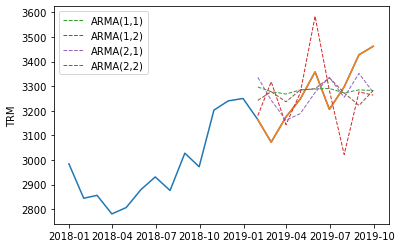

In [47]:
#Cálculo de la TRM observada a partir de la serie futura transformada
TRM_observada=TRMm2.iloc[-1,0]/np.cumprod(TRM_estacionaria_1['TRM'].tail(9)) 
pronostico1=TRMm2.iloc[-1,0]/pronostico['(1,1)']
pronostico2=TRMm2.iloc[-1,0]/pronostico['(1,2)']
pronostico3=TRMm2.iloc[-1,0]/pronostico['(2,1)']
pronostico4=TRMm2.iloc[-1,0]/pronostico['(2,2)']

    
plt.plot(TRMm.loc['2017-12':'2019-09'])
plt.plot(TRM_observada)
plt.plot(pronostico1,'--',linewidth=1.0, label='ARMA(1,1)')
plt.plot(pronostico2,'--',linewidth=1.0, label='ARMA(1,2)')
plt.plot(pronostico3,'--',linewidth=1.0, label='ARMA(2,1)')
plt.plot(pronostico4,'--',linewidth=1.0, label='ARMA(2,2)')
plt.ylabel('TRM')
plt.legend()
plt.show()

* Cálculo de las metricas de desempeño de pronóstico

In [49]:
RMSE1=rmse(TRM_observada,pronostico1,0)
MSE1=mse(TRM_observada,pronostico1,0)
MAE1=meanabs(TRM_observada,pronostico1,0)
MAPE1=np.mean(np.abs((np.array(TRM_observada)-np.array(pronostico1))/np.array(TRM_observada)))*100

RMSE2=rmse(TRM_observada,pronostico2,0)
MSE2=mse(TRM_observada,pronostico2,0)
MAE2=meanabs(TRM_observada,pronostico2,0)
MAPE2=np.mean(np.abs((np.array(TRM_observada)-np.array(pronostico2))/np.array(TRM_observada)))*100

RMSE3=rmse(TRM_observada,pronostico3,0)
MSE3=mse(TRM_observada,pronostico3,0)
MAE3=meanabs(TRM_observada,pronostico3,0)
MAPE3=np.mean(np.abs((np.array(TRM_observada)-np.array(pronostico3))/np.array(TRM_observada)))*100

RMSE4=rmse(TRM_observada,pronostico4,0)
MSE4=mse(TRM_observada,pronostico4,0)
MAE4=meanabs(TRM_observada,pronostico4,0)
MAPE4=np.mean(np.abs((np.array(TRM_observada)-np.array(pronostico4))/np.array(TRM_observada)))*100

errores = {'Tipo de Error': ['RMSE','MSE','MAE','MAPE'],
        'ARMA(11)': [RMSE1,MSE1,MAE1,MAPE1],
        'ARMA(12)': [RMSE2,MSE2,MAE2,MAPE2],
        'ARMA(21)': [RMSE3,MSE3,MAE3,MAPE3],
        'ARMA(22)': [RMSE4,MSE4,MAE4,MAPE4]
        }
erroresDF=pd.DataFrame(errores,columns = ['Tipo de Error','ARMA(11)','ARMA(12)','ARMA(21)','ARMA(22)'])
erroresDF.set_index('Tipo de Error')
print(erroresDF)

  Tipo de Error      ARMA(11)      ARMA(12)      ARMA(21)      ARMA(22)
0          RMSE    122.578169    169.044857    119.717582    129.082819
1           MSE  15025.407549  28576.163564  14332.299476  16662.374246
2           MAE    107.728336    138.498570    103.851714    109.896932
3          MAPE      3.307759      4.211512      3.188804      3.357844


* Test de Diebold y Mariano para comparación de diferencia estadística de los modelos

In [50]:
print('-------------ARMA(1,1) vs. ARMA(1,2)----------------------')
print(dm_test(TRM_observada,pronostico1,pronostico2,1,"MSE"))
print('-------------ARMA(1,1) vs. ARMA(2,1)----------------------')
print(dm_test(TRM_observada,pronostico1,pronostico3,1,"MSE"))
print('-------------ARMA(1,1) vs. ARMA(2,2)----------------------')
print(dm_test(TRM_observada,pronostico1,pronostico4,1,"MSE"))
print('-------------ARMA(1,2) vs. ARMA(2,1)----------------------')
print(dm_test(TRM_observada,pronostico2,pronostico3,1,"MSE"))
print('-------------ARMA(1,2) vs. ARMA(2,2)----------------------')
print(dm_test(TRM_observada,pronostico2,pronostico4,1,"MSE"))
print('-------------ARMA(2,1) vs. ARMA(2,2)----------------------')
print(dm_test(TRM_observada,pronostico3,pronostico4,1,"MSE"))

-------------ARMA(1,1) vs. ARMA(1,2)----------------------
dm_return(DM=-1.3876782293612036, p_value=0.2026619660950555)
-------------ARMA(1,1) vs. ARMA(2,1)----------------------
dm_return(DM=0.22173198285916698, p_value=0.8300778847602187)
-------------ARMA(1,1) vs. ARMA(2,2)----------------------
dm_return(DM=-0.5231001078948336, p_value=0.6150797348028652)
-------------ARMA(1,2) vs. ARMA(2,1)----------------------
dm_return(DM=1.3650321313179623, p_value=0.20939277578505422)
-------------ARMA(1,2) vs. ARMA(2,2)----------------------
dm_return(DM=1.1730103064178414, p_value=0.2745322242048126)
-------------ARMA(2,1) vs. ARMA(2,2)----------------------
dm_return(DM=-0.4370336357182361, p_value=0.6736437848882293)


### Punto 4: GARCH(1,1), EWMA e Índice Kospi

In [51]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import arch_model
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import math
from scipy.stats import t as student_t

* Importación de los índices

In [52]:
Indices=pd.read_csv('oxfordmanrealizedvolatilityindices.csv', parse_dates=True)
Indices['Unnamed: 0'] = Indices['Unnamed: 0'].astype(str).str[:-6] #Borra los usos horarios
Indices['Unnamed: 0'] = pd.to_datetime(Indices['Unnamed: 0'])   #Vuelve Datetime la columna
Indices=Indices.set_index('Unnamed: 0')     #Define indice

KOSPI=Indices.groupby('Symbol').get_group('.KS11') #Agrupa los datos correspondientes al KOSPI

KOSPIa=KOSPI.loc['2015-12-29':'2017-12-28'] 
KOSPIb=KOSPI.loc['2017-12-28':'2018-09-30']

* Cálculo de los retornos logarítmicos

In [53]:
logKOSPIa=(np.log(KOSPIa['close_price']).diff()).dropna() #Calculo Log Retornos
logKOSPIb=(np.log(KOSPIb['close_price']).diff()).dropna() #Calculo Log Retornos serie a pronosticar
logKOSPIc=logKOSPIa.append(logKOSPIb)   #Serie completa (Rolling window)

VentanaRolling=len(logKOSPIa.index) #Tamaño ventana Rolling Window
Simulaciones=len(logKOSPIb.index) #Tamaño ventana a pronosticar

* Definición modelo GARCH(1,1) ~N

In [54]:
#Garch(1,1)
mGARCH=arch_model(logKOSPIa)
GARCHresulatdos=mGARCH.fit(disp = 'off')
print(GARCHresulatdos.summary())
residuos=GARCHresulatdos.resid / GARCHresulatdos.conditional_volatility

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            close_price   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                1763.11
Distribution:                  Normal   AIC:                          -3518.21
Method:            Maximum Likelihood   BIC:                          -3501.44
                                        No. Observations:                  489
Date:                Sat, Nov 21 2020   Df Residuals:                      485
Time:                        20:43:31   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.0612e-04  1.041e-05     48.635      0.000 [4.

* Gráfica de residuos estandarizados

No handles with labels found to put in legend.


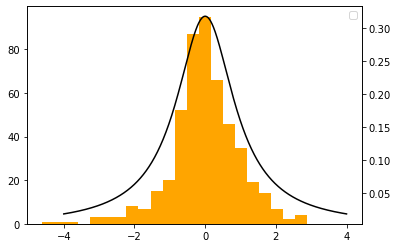

In [55]:
fig,ax = plt.subplots()
w = 0.35
n = math.ceil((residuos.max() - residuos.min())/w)
ax.hist(residuos,bins = n, facecolor = 'orange')

ax2=ax.twinx()
mu = 0
x = np.linspace(-4, 4, 1000)
dist = student_t(1, 0)
ax2.plot(x, dist.pdf(x),c='black')
plt.legend()
plt.show()

* Definición modelo GARCH(1,1) ~ T de Student

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  close_price   R-squared:                     -28.262
Mean Model:                   Constant Mean   Adj. R-squared:                -28.262
Vol Model:                            GARCH   Log-Likelihood:                895.457
Distribution:      Standardized Student's t   AIC:                          -1780.91
Method:                  Maximum Likelihood   BIC:                          -1759.95
                                              No. Observations:                  489
Date:                      Sat, Nov 21 2020   Df Residuals:                      484
Time:                              20:43:44   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

<Figure size 432x288 with 0 Axes>

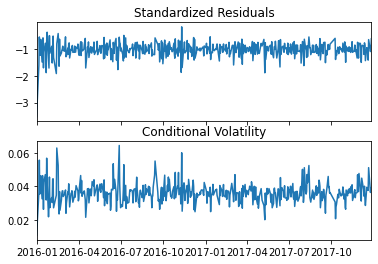

In [56]:
mGARCH2=arch_model(logKOSPIa, p = 1, q = 1,mean = 'constant', vol = 'GARCH',dist = 't')
GARCH2resulatdos=mGARCH2.fit(disp = 'off')
print(GARCH2resulatdos.summary())
residuost=GARCH2resulatdos.resid / GARCH2resulatdos.conditional_volatility

fig1 = plt.figure()
GARCH2resulatdos.plot()
plt.show()

* Definición modelo EWMA utilizando la función de movimiento ponderado exponencial (EWM)

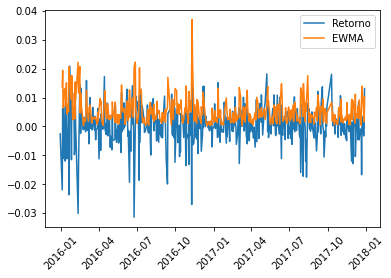

In [57]:
#EWMA
EWMA=(logKOSPIa.ewm(alpha=0.95).std()).dropna()
plt.plot(logKOSPIa,label='Retorno')
plt.plot(EWMA,label='EWMA')
plt.xticks(rotation=45)
plt.legend()
plt.show()

* Cálculo de volatilidad diaría realizada

In [58]:
#Cálculo de volatilidad diaria realizada
ventanaVolR=logKOSPIc
volRealizada=((ventanaVolR.rolling(2).std()).dropna()).tail(Simulaciones)
volRealizada=pd.DataFrame(data=volRealizada)

* Cálculo de pronóstico de volatilidad

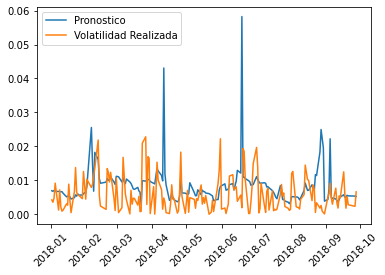

In [59]:
#Cálculo volatilidad con rolling window
VentanadePronostico=22
pronostico=pd.DataFrame(columns=['h.1'])
for i in range(Simulaciones+1):
        modelRW = arch_model(logKOSPIc.iloc[(VentanaRolling-VentanadePronostico)+i:VentanaRolling+i]*100, p = 1, q = 1,
                             mean = 'constant', vol = 'GARCH',dist = 't') #Definición Rolling Window de 12 meses
        model_resultados=modelRW.fit(disp = 'off')                                          #Ajuste modelo ARMA
        volRW=(model_resultados.forecast(horizon=1).variance)    #Pronóstico GARCH
        pronostico=pronostico.append(volRW.tail(1))
                                          #Resultados ARMA(2,1)
pronostico=(pronostico/((100)**2)).dropna()      
pronostico=((pronostico.reindex(logKOSPIb.index))**(1/2))

Resultados=pd.concat([pronostico,volRealizada], axis=1)

fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.plot(pronostico,label='Pronostico')
ax1.plot(volRealizada,label='Volatilidad Realizada')
plt.xticks(rotation=45)
ax1.legend()
plt.show()

* Métricas de desempeño de pronóstico (MAPE,RMSE,MSE,MAE)

In [60]:
#Métricas de desempeño de pronóstico
MAPEg=np.mean(np.abs((np.array(volRealizada)-np.array(pronostico))/np.array(volRealizada)))*100
RMSEg=float(rmse(volRealizada,pronostico,0))
MSEg=float(mse(volRealizada,pronostico,0))
MAEg=float(meanabs(volRealizada,pronostico,0))

errores = {'Tipo de Error': ['RMSE','MSE','MAE','MAPE'],'GARCH(1,1)': [RMSEg,MSEg,MAEg,MAPEg]}
errores=pd.DataFrame(errores,columns = ['Tipo de Error','GARCH(1,1)'])
errores.set_index('Tipo de Error')
print(errores)

  Tipo de Error  GARCH(1,1)
0          RMSE    0.007774
1           MSE    0.000060
2           MAE    0.004931
3          MAPE  617.589732
